## Импорт библиотек и настройка путей

In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки отображения
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 30)
pd.options.display.float_format = '{:.2f}'.format

# Инициализация путей
root = Path(os.getcwd()).parent.parent
data_in = root / 'data' / 'processed_data'
data_out = root / 'data' / 'eda_data'

print("Пути инициализированы:")
print(f"Processed data: {data_in}")
print(f"EDA data: {data_out}")

Пути инициализированы:
Processed data: /Users/aleksey.sushchikh/Desktop/GitHub/MIFIHackatonSberAutoSubscriptionAnalysis/data/processed_data
EDA data: /Users/aleksey.sushchikh/Desktop/GitHub/MIFIHackatonSberAutoSubscriptionAnalysis/data/eda_data


## Загрузка данных

In [5]:
# Загрузка данных
print("\nЗагружаем предобработанные данные...")
data = pd.read_pickle(data_in / 'data_processed.pkl')
print("\nДанные успешно загружены!")


Загружаем предобработанные данные...

Данные успешно загружены!


## Первичный анализ данных

In [7]:
 def generate_summary(df: pd.DataFrame, name: str, sample_size: int = 3) -> None:
    """Генерация расширенной сводки по данным примерами"""
    print(f"\n{'='*50} {name.upper()} {'='*50}")
    print(f"Общее количество записей: {df.shape[0]:,}")
    print(f"Количество признаков: {df.shape[1]}")

    # Типы данных
    print("\nТипы данных:")
    print(df.dtypes.value_counts().rename('count').to_frame())

    # Пропуски
    missing = df.isna().sum().sort_values(ascending=False)
    missing_pct = (missing / df.shape[0] * 100).round(2)
    missing_df = pd.concat([missing, missing_pct], axis=1, keys=['count', '%']).query('count > 0')
    if not missing_df.empty:
        print("\nПропущенные значения:")
        print(missing_df)
    else:
        print("\nПропущенных значений нет")

    # Дубликаты
    dupes = df.duplicated().sum()
    print(f"\nДубликаты: {dupes} ({dupes/df.shape[0]*100:.2f}%)")

    # Примеры
    print(f"\nПервые {sample_size} записей:")
    display(df.head(sample_size))


def analyze_column(df: pd.DataFrame, col: str, max_display: int = 50) -> None:
    """Полный анализ колонки с выводом всех уникальных значений"""
    print(f"\n{'-'*60}")
    print(f"Полный анализ колонки: {col}")

    # Проверка существования колонки
    if col not in df.columns:
        print(f"Колонка {col} не найдена!")
        return

    # Пропуски
    na_count = df[col].isna().sum()
    print(f"Пропуски: {na_count} ({na_count/len(df)*100:.1f}%)")

    # Количество уникальных значений
    unique_count = df[col].nunique(dropna=False)
    print(f"Уникальных значений: {unique_count}")

    # Вывод всех значений для категориальных данных
    if unique_count <= max_display:
        print("\nВсе значения:")
        print(df[col].unique())
    else:
        print(f"\nСлишком много значений (> {max_display}). Примеры:")
        print(df[col].dropna().sample(10).unique())

    # Частотный анализ для числовых колонок
    if pd.api.types.is_numeric_dtype(df[col]):
        print("\nОписательная статистика:")
        print(df[col].describe())
    else:
        print("\nТоп-10 значений:")
        print(df[col].value_counts(dropna=False).head(10))

def summarize_dataset(df: pd.DataFrame,
                      name: str,
                      target_col: str = 'is_target',
                      analyzer_func=analyze_column,
                      summary_func=generate_summary,
                      sample_size: int = 3):
    """
    Выводит полную сводку по датафрейму:
      1. Генерирует общую статистику (generate_summary).
      2. Запускает анализ по каждому столбцу (analyze_column).
      3. Считает и выводит баланс целевой переменной.
      4. Строит столбчатую диаграмму распределения target_col.

    Параметры
    ---------
    df : pd.DataFrame
        Датафрейм для анализа.
    name : str
        Название датасета (для generate_summary).
    target_col : str, default='is_target'
        Имя целевого столбца, по которому строится баланс.
    analyzer_func : callable
        Функция для анализа колонки (принимает df, col, sample_size).
    summary_func : callable
        Функция для общей сводки (принимает df, name, sample_size).
    sample_size : int, default=3
        Число примеров для generate_summary.
    """
    # 1. Общая сводка
    summary_func(df, name, sample_size)

    # 2. Анализ каждой колонки
    for col in df.columns:
        analyzer_func(df, col)

    # 3. Баланс целевой переменной
    counts = df[target_col].fillna(0).value_counts().sort_index()
    total = counts.sum()
    print("\nБаланс целевой переменной:")
    for label, count in counts.items():
        pct = count / total * 100
        print(f"{target_col} = {label}: {count} записей ({pct:.2f}%)")

    # 4. График распределения
    plt.figure(figsize=(6,4))
    plt.bar(counts.index.astype(str), counts.values, color='skyblue')
    plt.xlabel(target_col)
    plt.ylabel('Количество сессий')
    plt.title(f'Распределение {target_col}')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


## Анализ и обработка


================================================== ДАННЫЕ ==================================================
Общее количество записей: 15,684,274
Количество признаков: 29

Типы данных:
                 count
string[python]      18
Int32                8
datetime64[ns]       2
timedelta64[ns]      1

Пропущенных значений нет

Дубликаты: 0 (0.00%)

Первые 3 записей:


,session_id,client_id,visit_datetime,visit_hour,visit_weekday,is_weekend,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_height,device_screen_width,device_browser,geo_country,geo_city,hit_date_dt,hit_time_td,hit_number,hit_referer,hit_page_path,event_category,event_action,event_label,is_target
0,9055434745589932991.163775...,2108382700.1637753791,2021-11-24 14:36:32,14,2,0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,720,360,Chrome,russia,Zlatoust,2021-11-24,0 days 00:00:03.665000,3,missing,podpiska.sberauto.com/,sub_page_view,sub_landing,missing,0
1,9055434745589932991.163775...,2108382700.1637753791,2021-11-24 14:36:32,14,2,0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,720,360,Chrome,russia,Zlatoust,2021-11-24,0 days 00:00:46.592000,4,missing,podpiska.sberauto.com/,sub_button_click,sub_view_cars_click,vodKSlUobUWTVlgsJqdI,1
2,905544597018549464.1636867...,210838531.1636867288,2021-11-14 08:21:30,8,6,1,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,854,385,Samsung Internet,russia,Moscow,2021-11-14,0 days 00:00:00.921000,3,missing,podpiska.sberauto.com/,sub_page_view,sub_landing,missing,0



------------------------------------------------------------
Полный анализ колонки: session_id
Пропуски: 0 (0.0%)
Уникальных значений: 1732170

Слишком много значений (> 50). Примеры:
<StringArray>
['4653271740258347172.1635149990.1635149990',
  '726691043435460631.1634580505.1634580505',
 '3556695606660318514.1630422323.1630422323',
 '6054493593530762057.1632111795.1632111795',
 '5298719180681132143.1628190839.1628190839',
 '4573734598108631966.1630393247.1630393247',
 '9094725338329760518.1625539334.1625539334',
 '6555158846053821393.1632381907.1632381907',
 '5931826071980648896.1640933827.1640933836',
 '4007561576666509016.1622565206.1622565206']
Length: 10, dtype: string

Топ-10 значений:
session_id
5442565791571325612.1632449195.1632449195    768
6568868914238486437.1632270313.1632270313    678
5959671972744778783.1632490527.1632490600    548
7452598043578978502.1632358598.1632358598    514
3070792010704358528.1629752408.1629752408    498
686125592720823356.1634587719.1634587719 

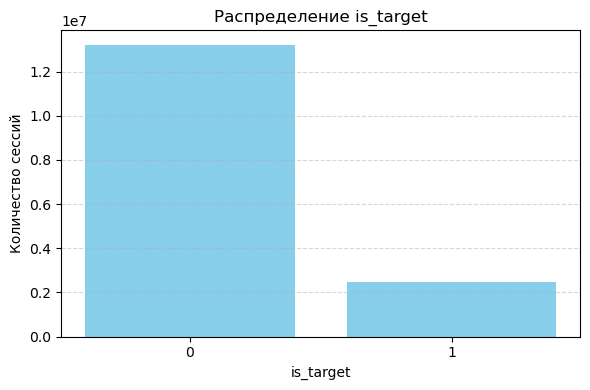

In [9]:
test0 = data.copy()

summarize_dataset(test0, "Данные")

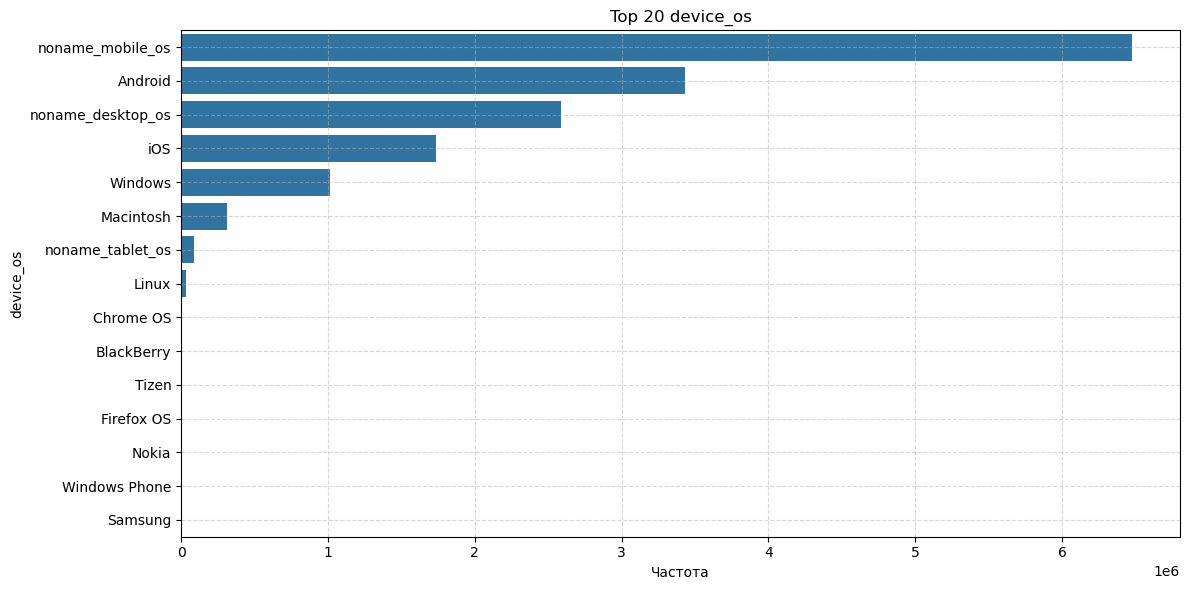

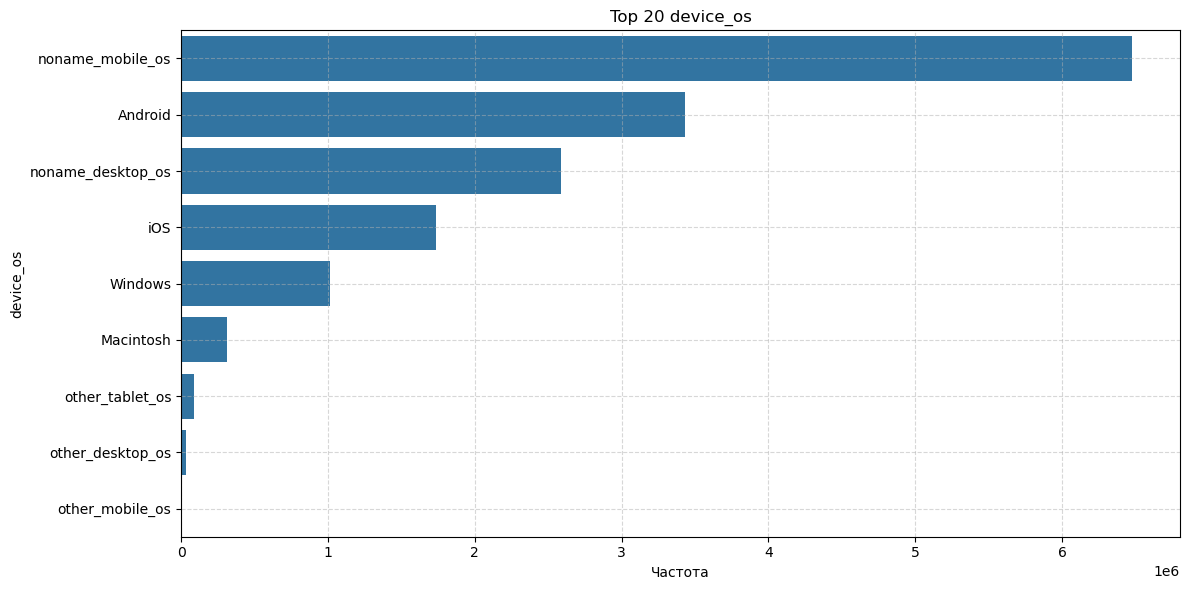

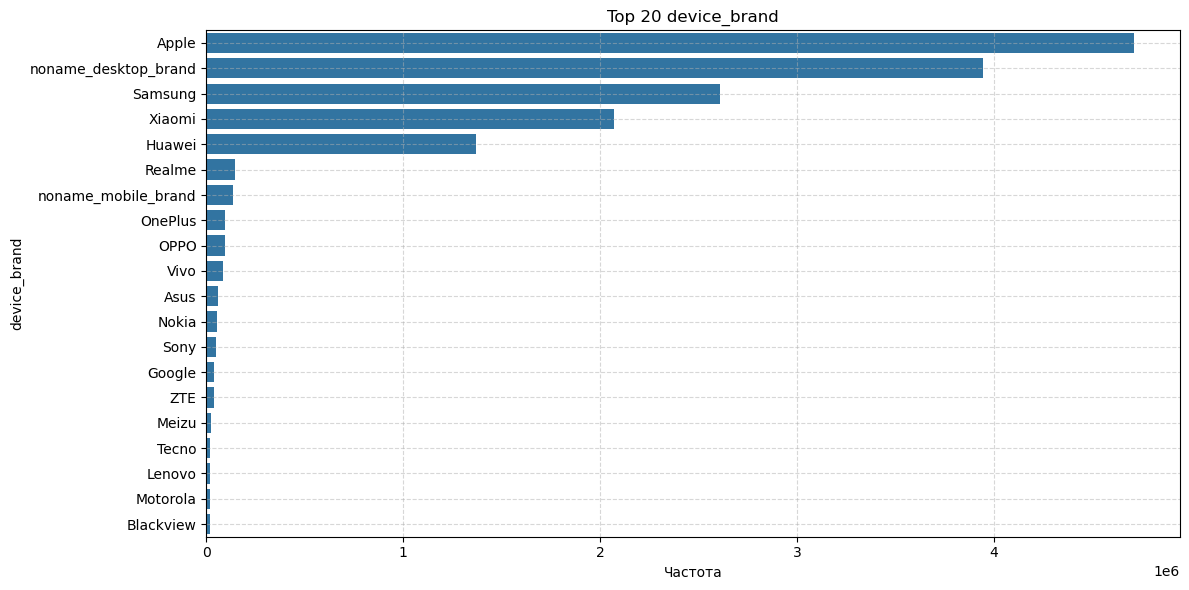

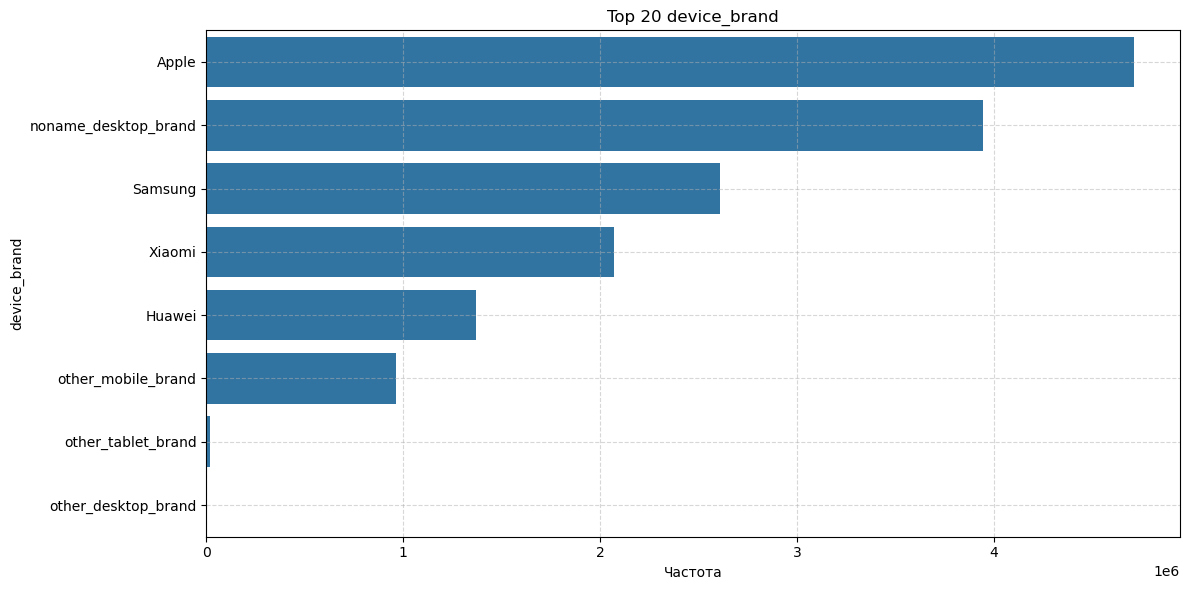

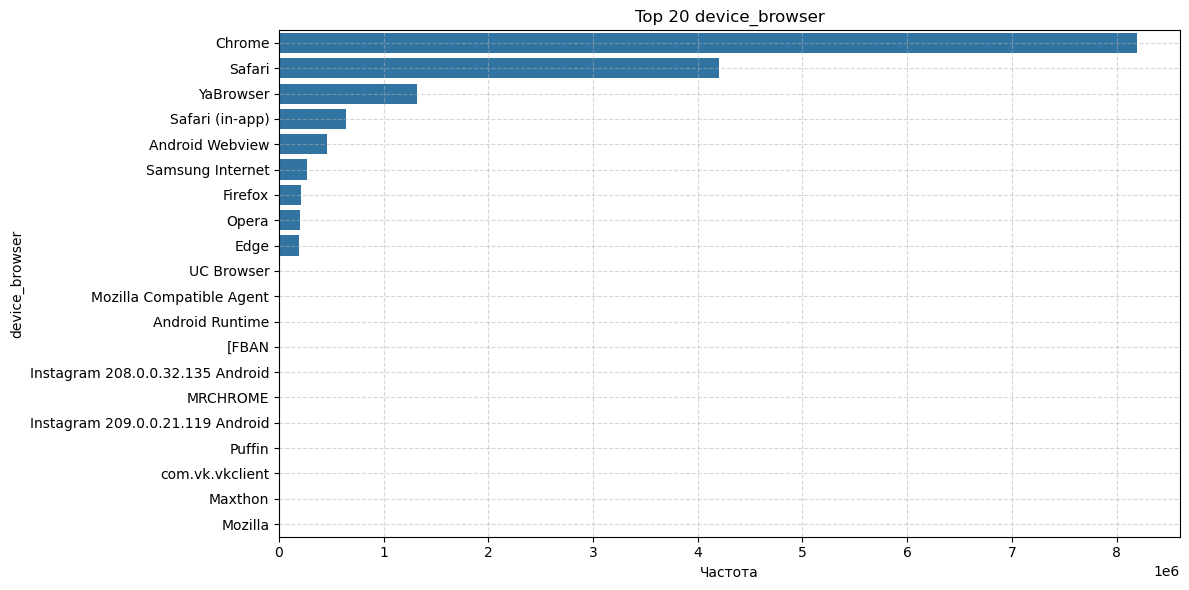

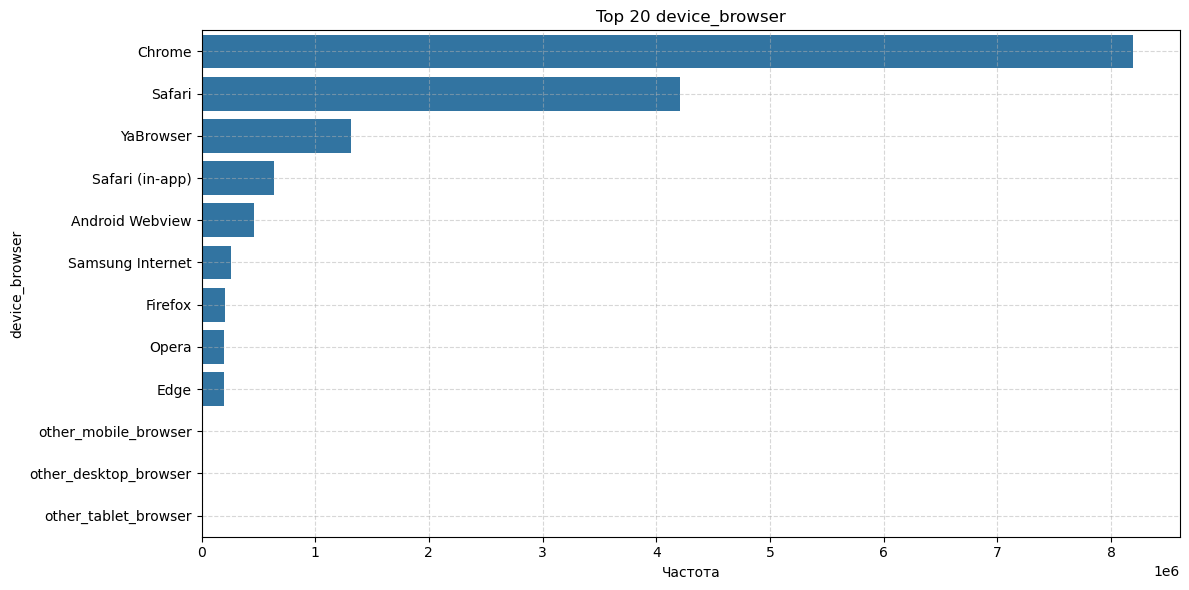

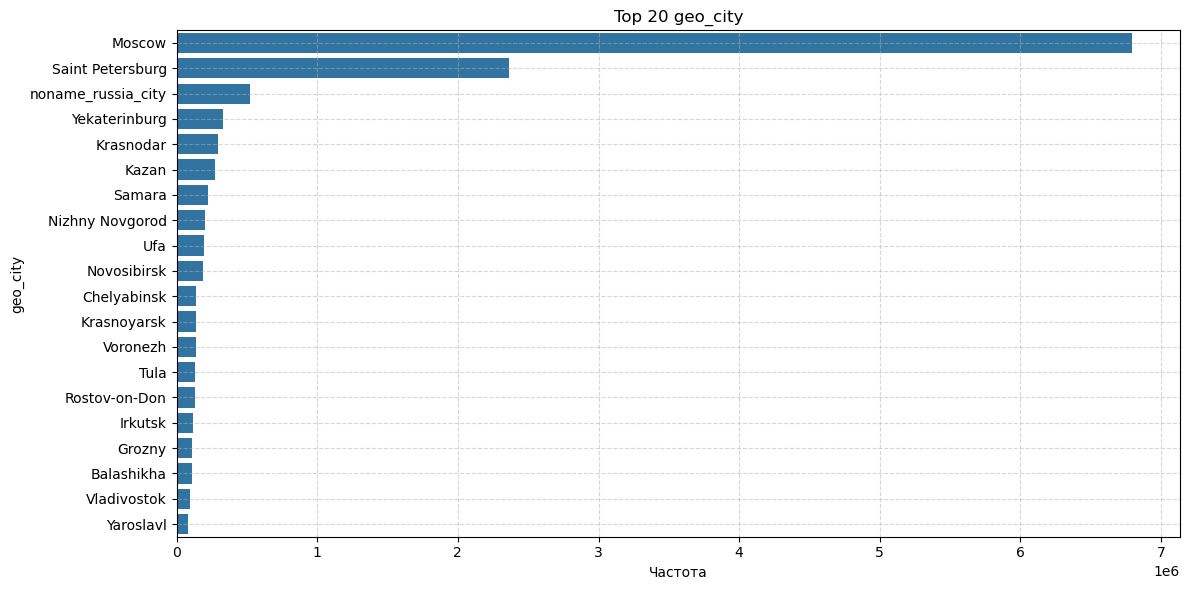

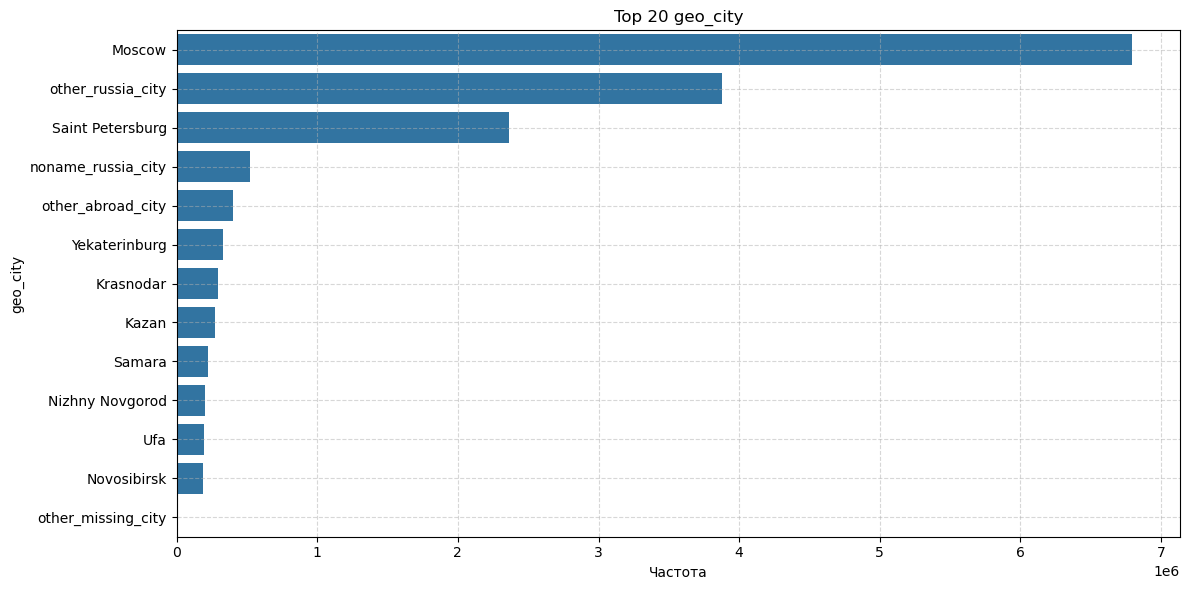


================================================== ДАННЫЕ ==================================================
Общее количество записей: 15,684,274
Количество признаков: 29

Типы данных:
                 count
string[python]      14
Int32                8
object               4
datetime64[ns]       2
timedelta64[ns]      1

Пропущенных значений нет

Дубликаты: 0 (0.00%)

Первые 3 записей:


,session_id,client_id,visit_datetime,visit_hour,visit_weekday,is_weekend,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_height,device_screen_width,device_browser,geo_country,geo_city,hit_date_dt,hit_time_td,hit_number,hit_referer,hit_page_path,event_category,event_action,event_label,is_target
0,9055434745589932991.163775...,2108382700.1637753791,2021-11-24 14:36:32,14,2,0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,720,360,Chrome,russia,other_russia_city,2021-11-24,0 days 00:00:03.665000,3,missing,podpiska.sberauto.com/,sub_page_view,sub_landing,missing,0
1,9055434745589932991.163775...,2108382700.1637753791,2021-11-24 14:36:32,14,2,0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,720,360,Chrome,russia,other_russia_city,2021-11-24,0 days 00:00:46.592000,4,missing,podpiska.sberauto.com/,sub_button_click,sub_view_cars_click,vodKSlUobUWTVlgsJqdI,1
2,905544597018549464.1636867...,210838531.1636867288,2021-11-14 08:21:30,8,6,1,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,854,385,Samsung Internet,russia,Moscow,2021-11-14,0 days 00:00:00.921000,3,missing,podpiska.sberauto.com/,sub_page_view,sub_landing,missing,0



------------------------------------------------------------
Полный анализ колонки: session_id
Пропуски: 0 (0.0%)
Уникальных значений: 1732170

Слишком много значений (> 50). Примеры:
<StringArray>
['4119629531266185038.1632925522.1632925522',
  '933069685196986658.1624906018.1624906018',
 '3688266518112856544.1628793318.1628793318',
 '4197924813689629778.1640279122.1640279122',
 '7767172061208485014.1638636698.1638636698',
 '2013456171505468875.1634125260.1634125260',
 '2621915465243872896.1626787592.1626787592',
  '363940480737809726.1640174919.1640174919',
 '1158842990536110447.1633379855.1633379855',
 '9031277354125320214.1621846229.1621846229']
Length: 10, dtype: string

Топ-10 значений:
session_id
5442565791571325612.1632449195.1632449195    768
6568868914238486437.1632270313.1632270313    678
5959671972744778783.1632490527.1632490600    548
7452598043578978502.1632358598.1632358598    514
3070792010704358528.1629752408.1629752408    498
686125592720823356.1634587719.1634587719 

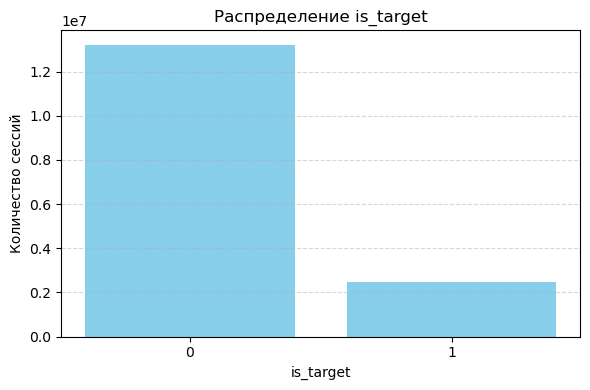

In [10]:
test1 = test0.copy()
#=========================================================================
# RLE
def rare_label_encoding(df: pd.DataFrame,
                        cols: str | list[str],
                        threshold: float = 0.01,
                        group_col: str | None = None,
                        other_label_template: str | None = None
                       ) -> pd.DataFrame:
    """
    Универсальный Rare Label Encoder.

    Параметры
    ---------
    df : pd.DataFrame
        Исходный датафрейм.
    cols : str or list[str]
        Один или несколько категориальных столбцов.
    threshold : float, default=0.01
        Порог по относительной частоте (< threshold считается редким).
    group_col : str | None, default=None
        Если задан, будет использоваться для шаблона other_label_template.
    other_label_template : str | None, default=None
        Шаблон для редких меток. Поддерживает {group} и {col}.
    """
    df = df.copy()

    # Приводим вход к списку
    if isinstance(cols, str):
        cols = [cols]

    for col in cols:
        freq = df[col].value_counts(normalize=True)
        rare_vals = set(freq[freq < threshold].index)

        if group_col and other_label_template:
            template = other_label_template
        elif group_col:
            template = f"other_{{group}}_{col}"
        else:
            template = other_label_template or f"other_{col}"

        if group_col:
            def repl(val, grp):
                return template.format(group=grp, col=col) if val in rare_vals else val
            df[col] = df.apply(lambda r: repl(r[col], r[group_col]), axis=1)
        else:
            df[col] = df[col].where(~df[col].isin(rare_vals),
                                    template.format(col=col))
    return df

# График частоты значения
def plot_top_categories(df, col, top_n=20, figsize=(12,6), orient='h', title=None):
    """
    Строит countplot для топ-N самых частых значений в столбце.

    Параметры:
    -----------
    df : pd.DataFrame
        Ваш фрейм данных.
    col : str
        Имя столбца, категории которого нужно визуализировать.
    top_n : int, default=20
        Сколько самых частых категорий отобразить.
    figsize : tuple, default=(12,6)
        Размер фигуры.
    orient : {'h','v'}, default='h'
        Ориентация графика: 'h' — горизонтально, 'v' — вертикально.
    title : str or None
        Заголовок графика. Если None, ставится "Top {top_n} {col}".
    """
    # Получаем топ-N категорий
    top_categories = df[col].value_counts().nlargest(top_n).index

    plt.figure(figsize=figsize)
    if orient == 'h':
        sns.countplot(data=df, y=col, order=top_categories)
        plt.xlabel('Частота')
        plt.ylabel(col)
    else:
        sns.countplot(data=df, x=col, order=top_categories)
        plt.ylabel('Частота')
        plt.xlabel(col)

    if title:
        plt.title(title)
    else:
        plt.title(f"Top {top_n} {col}")

    plt.grid(True, axis='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

#==========================================================================
# Профильтруем девайсы
#==========================================================================
# Top-20
plot_top_categories(test1, 'device_os', top_n=20)

# Rare Label Encoding
test1 = rare_label_encoding(test1,
                           'device_os',
                           threshold=0.01,
                           group_col='device_category',
                           other_label_template='other_{group}_os')

#Top-20
plot_top_categories(test1, 'device_os', top_n=20)
#==========================================================================
# Top-20
plot_top_categories(test1, 'device_brand', top_n=20)

# Rare Label Encoding
test1 = rare_label_encoding(test1,
                           'device_brand',
                           threshold=0.02,
                           group_col='device_category',
                           other_label_template='other_{group}_brand')

# Top-20
plot_top_categories(test1, 'device_brand', top_n=20)
#==========================================================================
# Top-20
plot_top_categories(test1, 'device_browser', top_n=20)

# Rare Label Encoding
test1 = rare_label_encoding(test1,
                           'device_browser',
                           threshold=0.005,
                           group_col='device_category',
                           other_label_template='other_{group}_browser')

# Top-20
plot_top_categories(test1, 'device_browser', top_n=20)
#==========================================================================
# Отфильтруем города
#==========================================================================
# Top-20
plot_top_categories(test1, 'geo_city', top_n=20)

# Rare Label Encoding
test1 = rare_label_encoding(test1,
                           'geo_city',
                           threshold=0.01,
                           group_col='geo_country',
                           other_label_template='other_{group}_city')

# Top-20
plot_top_categories(test1, 'geo_city', top_n=20)
#==========================================================================
summarize_dataset(test1, "Данные")


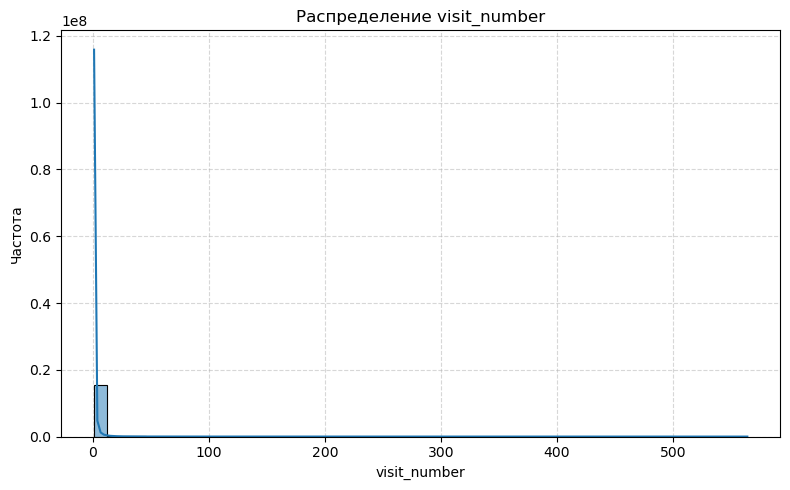

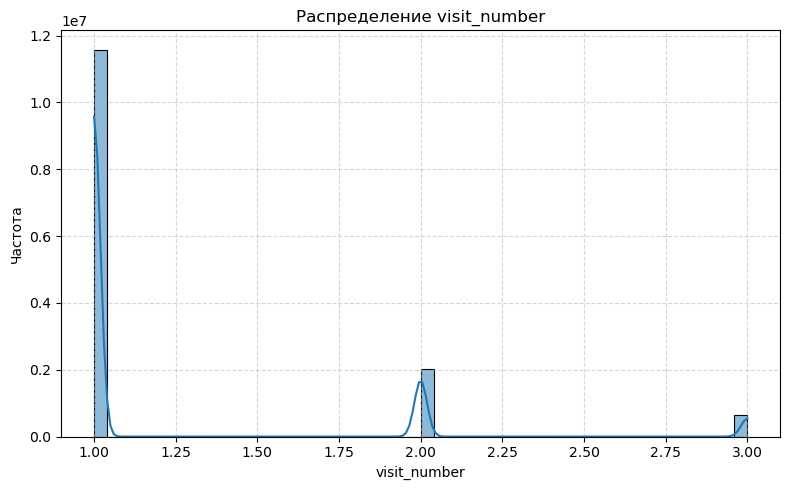

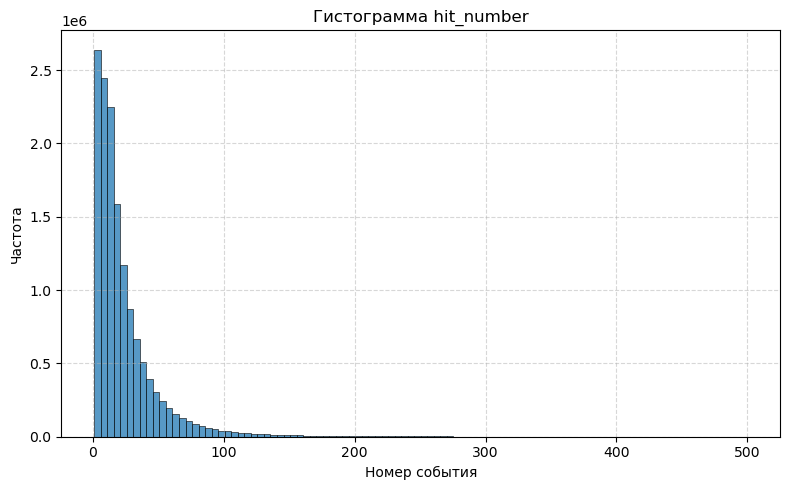

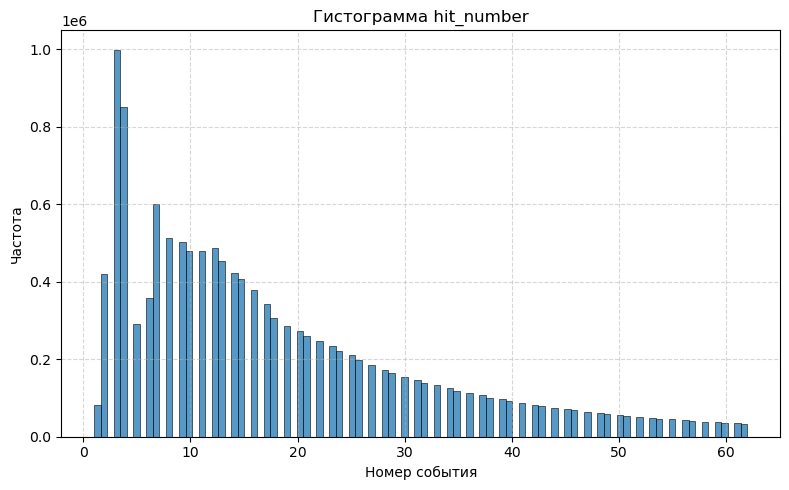


================================================== ДАННЫЕ ==================================================
Общее количество записей: 13,337,484
Количество признаков: 30

Типы данных:
                 count
string[python]      14
Int32                8
object               4
datetime64[ns]       2
timedelta64[ns]      1
Float64              1

Пропущенных значений нет

Дубликаты: 0 (0.00%)

Первые 3 записей:


,session_id,client_id,visit_datetime,visit_hour,visit_weekday,is_weekend,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_height,device_screen_width,device_browser,geo_country,geo_city,hit_date_dt,hit_time_td,hit_number,hit_referer,hit_page_path,event_category,event_action,event_label,is_target,aspect_ratio
0,9055434745589932991.163775...,2108382700.1637753791,2021-11-24 14:36:32,14,2,0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,720,360,Chrome,russia,other_russia_city,2021-11-24,0 days 00:00:03.665000,3,missing,podpiska.sberauto.com/,sub_page_view,sub_landing,missing,0,0.50
1,9055434745589932991.163775...,2108382700.1637753791,2021-11-24 14:36:32,14,2,0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,720,360,Chrome,russia,other_russia_city,2021-11-24,0 days 00:00:46.592000,4,missing,podpiska.sberauto.com/,sub_button_click,sub_view_cars_click,vodKSlUobUWTVlgsJqdI,1,0.50
2,905544597018549464.1636867...,210838531.1636867288,2021-11-14 08:21:30,8,6,1,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,854,385,Samsung Internet,russia,Moscow,2021-11-14,0 days 00:00:00.921000,3,missing,podpiska.sberauto.com/,sub_page_view,sub_landing,missing,0,0.45



------------------------------------------------------------
Полный анализ колонки: session_id
Пропуски: 0 (0.0%)
Уникальных значений: 1582604

Слишком много значений (> 50). Примеры:
<StringArray>
['1467415418417913168.1622875473.1622875473',
 '4520403894696404602.1621878396.1621878396',
  '392939043347420112.1629148113.1629148113',
 '1843897949356327664.1635029225.1635029225',
 '1280927620608402865.1633265081.1633265081',
 '8977814236885372285.1627344254.1627344254',
 '7920122679909594034.1636217785.1636217785',
  '837990581127892938.1631604683.1631604683',
 '6054033400678469688.1640648761.1640648761',
 '5516428641962718825.1630223306.1630223306']
Length: 10, dtype: string

Топ-10 значений:
session_id
1544572560279928739.1632436140.1632436140    120
5692861315757623740.1632356796.1632356796    120
6766315690481471549.1632423998.1632423998    116
6556325878862444653.1632368752.1632368752    116
6344040849605405862.1632382118.1632382118    116
4781656099508856169.1632511340.1632511340

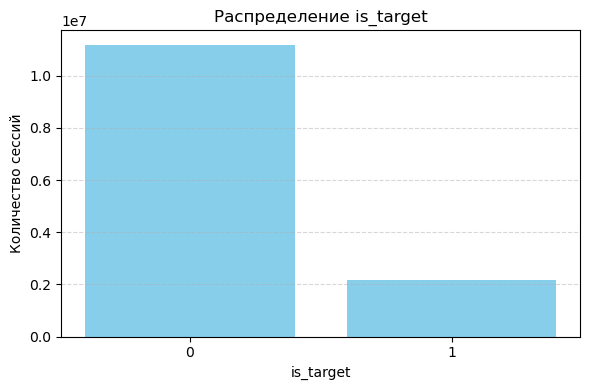

In [11]:
test2 = test1.copy()
#==========================================================================
# IQR
def filter_outliers_iqr(df: pd.DataFrame,
                        cols: str | list[str],
                        multiplier: float = 1.5,
                        return_bounds: bool = False
                       ) -> pd.DataFrame | tuple[pd.DataFrame, dict]:
    """
    Фильтрует выбросы по методу IQR (межквартильный размах).

    Параметры
    ----------
    df : pd.DataFrame
        Исходный датафрейм.
    cols : str or list[str]
        Столбец или список столбцов для фильтрации.
    multiplier : float, default=1.5
        Коэффициент для границ (1.5 * IQR).
    return_bounds : bool, default=False
        Если True, возвращает также словарь с рассчитанными границами для каждого столбца.

    Возвращает
    -------
    filtered_df : pd.DataFrame
        Датафрейм, отфильтрованный по всем указанным столбцам.
    bounds : dict (опционально)
        Для каждого столбца содержит (lower_bound, upper_bound).
    """
    df_filtered = df.copy()
    if isinstance(cols, str):
        cols = [cols]

    bounds = {}
    for col in cols:
        Q1 = df_filtered[col].quantile(0.25)
        Q3 = df_filtered[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - multiplier * IQR
        upper = Q3 + multiplier * IQR
        bounds[col] = (lower, upper)
        df_filtered = df_filtered[(df_filtered[col] >= lower) & (df_filtered[col] <= upper)]

    if return_bounds:
        return df_filtered, bounds
    return df_filtered

# График частот для численных значений
def plot_distribution(df, col, bins=50, kde=True, figsize=(8, 5),
                      xlabel=None, ylabel='Частота', title=None):
    """
    Строит гистограмму с опциональным KDE для числового столбца.

    Параметры:
    -----------
    df : pd.DataFrame
        Датафрейм с данными.
    col : str
        Имя числового столбца для визуализации.
    bins : int or sequence, default=50
        Число бинов или их границы.
    kde : bool, default=True
        Строить ли плотность KDE поверх гистограммы.
    figsize : tuple, default=(8,5)
        Размер фигуры (ширина, высота).
    xlabel : str or None, default=None
        Подпись оси X. Если None, ставится имя столбца.
    ylabel : str or None, default='Частота'
        Подпись оси Y.
    title : str or None, default=None
        Заголовок графика. Если None, ставится "Распределение {col}".
    """
    plt.figure(figsize=figsize)
    sns.histplot(data=df, x=col, bins=bins, kde=kde)
    plt.xlabel(xlabel or col)
    plt.ylabel(ylabel)
    plt.title(title or f"Распределение {col}")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

#==========================================================================
# Фильтруем visit_number
#==========================================================================
# График
plot_distribution(test2, 'visit_number', bins=50, kde=True,
                  title='Распределение visit_number')

test2 = filter_outliers_iqr(test2, 'visit_number', multiplier=1.5)

# График
plot_distribution(test2, 'visit_number', bins=50, kde=True,
                  title='Распределение visit_number')
#=============================================================
# Фильтруем hit_number
#=============================================================
# График
plot_distribution(test2, 'hit_number', bins=100, kde=False,
                  xlabel='Номер события', title='Гистограмма hit_number')

test2 = filter_outliers_iqr(test2, 'hit_number', multiplier=1.5)

# График
plot_distribution(test2, 'hit_number', bins=100, kde=False,
                  xlabel='Номер события', title='Гистограмма hit_number')
#=========================================================================
# Отфильтруем разрешения
#=========================================================================
# Вычисляем соотношение сторон
test2['aspect_ratio'] = test2['device_screen_width'] / test2['device_screen_height']

# Фильтруем строки с допустимым соотношением
test2 = test2[
    (test2['aspect_ratio'] >= 0.3) &
    (test2['aspect_ratio'] <= 2.5)
].copy()

# Удаляем вспомогательную колонку
# test2.drop(columns='aspect_ratio', inplace=True)

summarize_dataset(test2, "Данные")


Все даты совпадают.
Доля несовпадений: 0.0000%

================================================== ДАННЫЕ ==================================================
Общее количество записей: 13,337,484
Количество признаков: 29

Типы данных:
                 count
string[python]      14
Int32                8
object               4
datetime64[ns]       1
timedelta64[ns]      1
Float64              1

Пропущенных значений нет

Дубликаты: 0 (0.00%)

Первые 3 записей:


,session_id,client_id,visit_datetime,visit_hour,visit_weekday,is_weekend,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_height,device_screen_width,device_browser,geo_country,geo_city,hit_time_td,hit_number,hit_referer,hit_page_path,event_category,event_action,event_label,is_target,aspect_ratio
0,9055434745589932991.163775...,2108382700.1637753791,2021-11-24 14:36:32,14,2,0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,720,360,Chrome,russia,other_russia_city,0 days 00:00:03.665000,3,missing,podpiska.sberauto.com/,sub_page_view,sub_landing,missing,0,0.50
1,9055434745589932991.163775...,2108382700.1637753791,2021-11-24 14:36:32,14,2,0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,720,360,Chrome,russia,other_russia_city,0 days 00:00:46.592000,4,missing,podpiska.sberauto.com/,sub_button_click,sub_view_cars_click,vodKSlUobUWTVlgsJqdI,1,0.50
2,905544597018549464.1636867...,210838531.1636867288,2021-11-14 08:21:30,8,6,1,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,854,385,Samsung Internet,russia,Moscow,0 days 00:00:00.921000,3,missing,podpiska.sberauto.com/,sub_page_view,sub_landing,missing,0,0.45



------------------------------------------------------------
Полный анализ колонки: session_id
Пропуски: 0 (0.0%)
Уникальных значений: 1582604

Слишком много значений (> 50). Примеры:
<StringArray>
['7953603594953177036.1635006412.1635006412',
 '8169707674774978276.1639890661.1639890661',
 '4404382830748456405.1637307861.1637307861',
   '20433132438908503.1621847642.1621847678',
 '5100775476729202894.1635240141.1635240141',
 '8138103054835655732.1627408914.1627408914',
 '8040227995778380293.1636135435.1636135435',
 '7411940719220706452.1634159766.1634159766',
  '755766632002651898.1637648122.1637648122',
 '3363510524602455115.1631032396.1631032396']
Length: 10, dtype: string

Топ-10 значений:
session_id
1544572560279928739.1632436140.1632436140    120
5692861315757623740.1632356796.1632356796    120
6766315690481471549.1632423998.1632423998    116
6556325878862444653.1632368752.1632368752    116
6344040849605405862.1632382118.1632382118    116
4781656099508856169.1632511340.1632511340

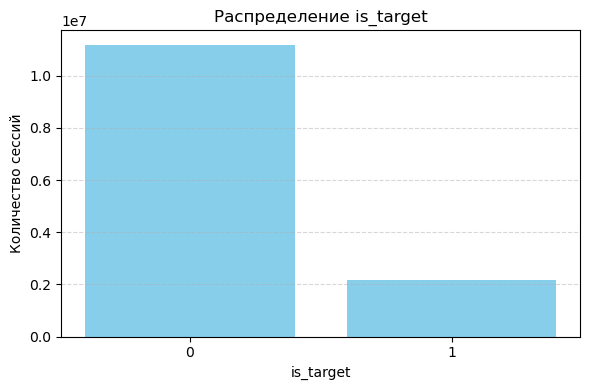

In [12]:
test3 = test2.copy()
#========================================================
# Проанализируем 'hit_date_dt' и 'visit_datetime'
#========================================================
# Извлечём из visit_datetime только дату
test3['visit_date_only'] = test3['visit_datetime'].dt.normalize()

# Сравним с hit_date_dt
mismatch = test3.loc[
    test3['visit_date_only'] != test3['hit_date_dt'].dt.normalize(),
    ['visit_datetime', 'hit_date_dt']
]

# Посмотрим, есть ли расхождения
if mismatch.empty:
    print("Все даты совпадают.")
else:
    print(f"Найдены несовпадения: {len(mismatch)} записей")
    display(mismatch.head(10))

total = len(test3)
bad = len(mismatch)
print(f"Доля несовпадений: {bad/total:.4%}")

# Удалим вспомогательную колонку 'visit_date_only'
test3.drop(columns=['visit_date_only'], inplace=True)

# Удалим колонку 'hit_date_dt', потому что даты визита и даты событий совпадают
test3.drop(columns=['hit_date_dt'], inplace=True)

summarize_dataset(test3, "Данные")


================================================== ДАННЫЕ ==================================================
Общее количество записей: 13,337,484
Количество признаков: 29

Типы данных:
                 count
string[python]      18
Int32                8
datetime64[ns]       1
timedelta64[ns]      1
Float32              1

Пропущенных значений нет

Дубликаты: 0 (0.00%)

Первые 3 записей:


,session_id,client_id,visit_datetime,visit_hour,visit_weekday,is_weekend,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_height,device_screen_width,device_browser,geo_country,geo_city,hit_time_td,hit_number,hit_referer,hit_page_path,event_category,event_action,event_label,is_target,aspect_ratio
0,9055434745589932991.163775...,2108382700.1637753791,2021-11-24 14:36:32,14,2,0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,720,360,Chrome,russia,other_russia_city,0 days 00:00:03.665000,3,missing,podpiska.sberauto.com/,sub_page_view,sub_landing,missing,0,0.50
1,9055434745589932991.163775...,2108382700.1637753791,2021-11-24 14:36:32,14,2,0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,720,360,Chrome,russia,other_russia_city,0 days 00:00:46.592000,4,missing,podpiska.sberauto.com/,sub_button_click,sub_view_cars_click,vodKSlUobUWTVlgsJqdI,1,0.50
2,905544597018549464.1636867...,210838531.1636867288,2021-11-14 08:21:30,8,6,1,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,854,385,Samsung Internet,russia,Moscow,0 days 00:00:00.921000,3,missing,podpiska.sberauto.com/,sub_page_view,sub_landing,missing,0,0.45



------------------------------------------------------------
Полный анализ колонки: session_id
Пропуски: 0 (0.0%)
Уникальных значений: 1582604

Слишком много значений (> 50). Примеры:
<StringArray>
['4276912281623143784.1638344040.1638344040',
 '7999693657804890220.1634197612.1634197612',
  '918273484219025370.1636379273.1636379273',
 '7790536245203834862.1630410733.1630410733',
 '8771637939622940886.1636864214.1636864214',
 '6011560052459083271.1623234096.1623234096',
 '8976616873023124187.1632776923.1632776923',
  '111543910084724349.1635075711.1635075711',
 '7253035502020641561.1631372060.1631372060',
 '2868506747651926993.1637526481.1637526481']
Length: 10, dtype: string

Топ-10 значений:
session_id
1544572560279928739.1632436140.1632436140    120
5692861315757623740.1632356796.1632356796    120
6766315690481471549.1632423998.1632423998    116
6556325878862444653.1632368752.1632368752    116
6344040849605405862.1632382118.1632382118    116
4781656099508856169.1632511340.1632511340

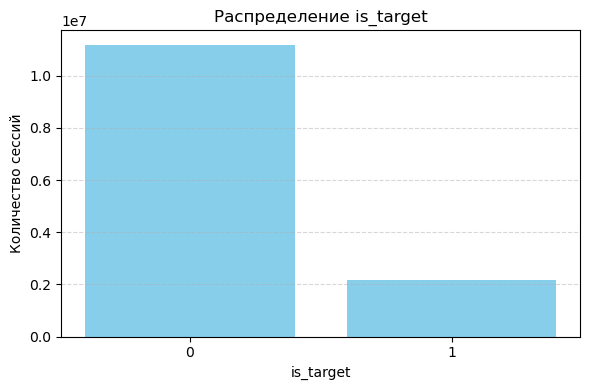

In [13]:
test4 = test3.copy()

# Приводим столбцы к правильным типам и заменяем значения
test4 = test4.convert_dtypes()

test4['aspect_ratio'] = test4['aspect_ratio'].astype('Float32')

summarize_dataset(test4, "Данные")

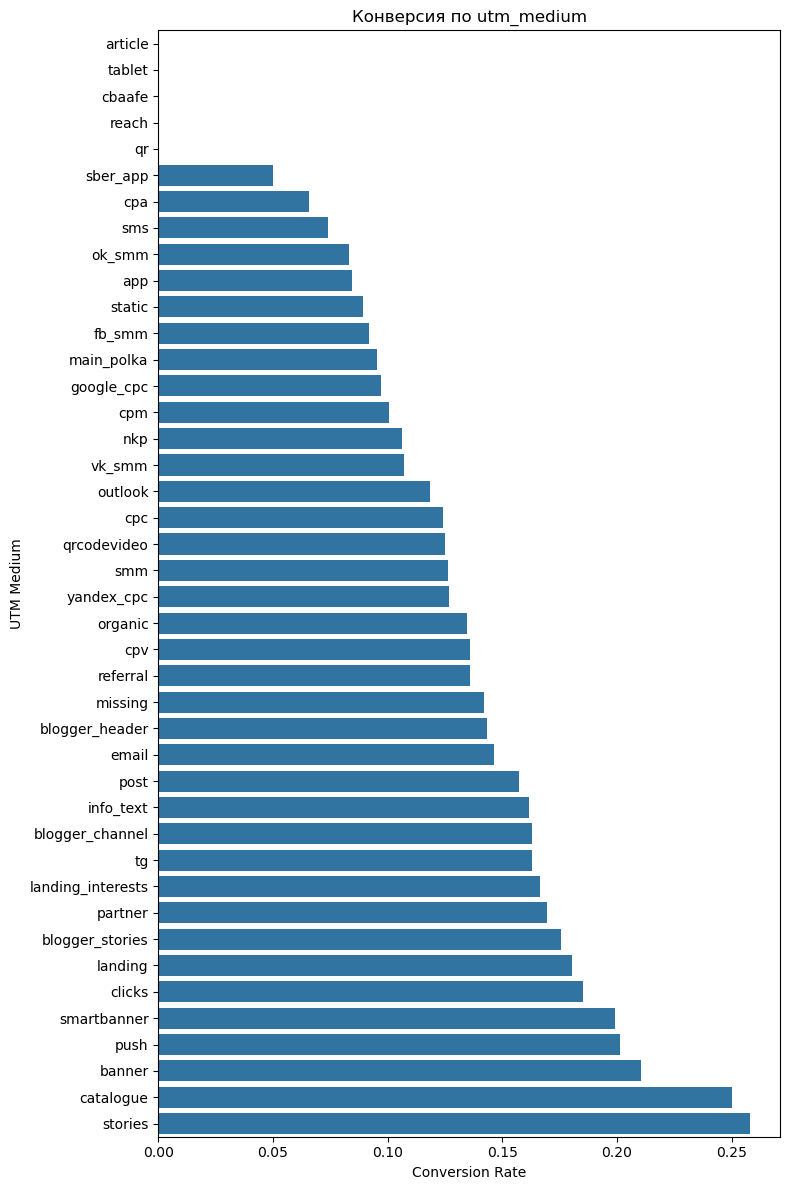

/var/folders/hn/tkf0_38d2d1ccs6db5_mfvmw0000gn/T/ipykernel_1502/2475552512.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('ar_bin')['is_target']


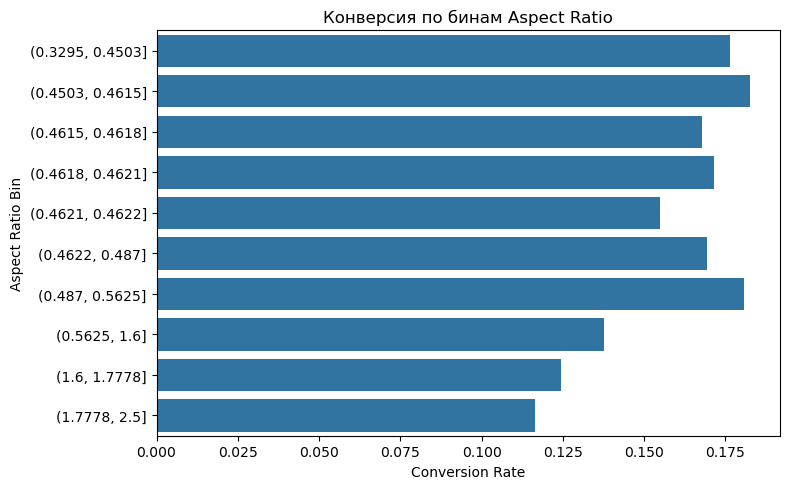

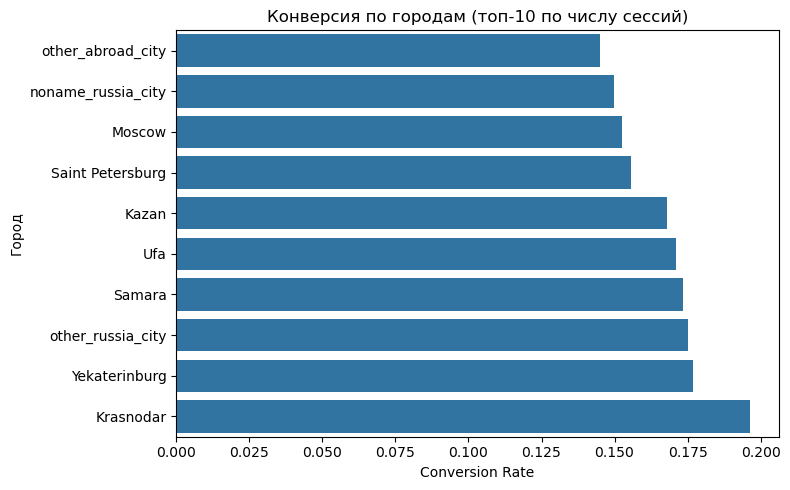

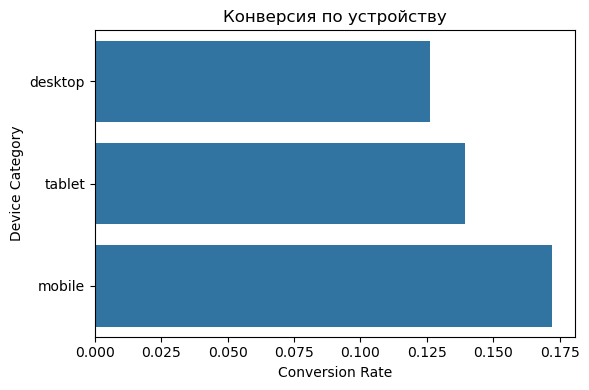

                 count      sum  conversion_rate
visit_number                                    
1             10865234  1804979             0.17
2              1878541   261138             0.14
3               593709    85267             0.14


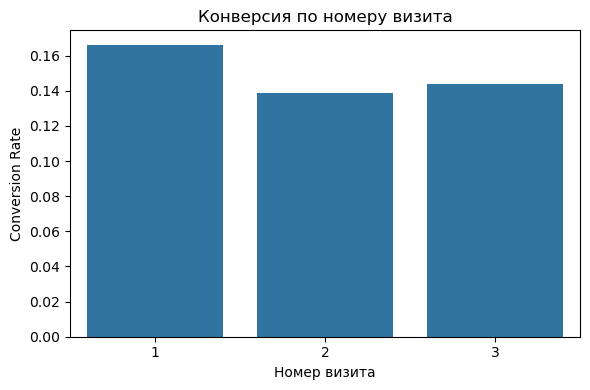

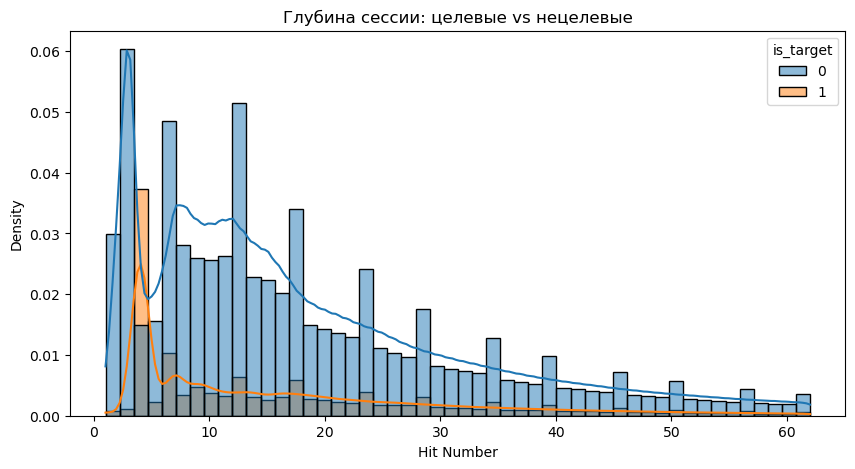

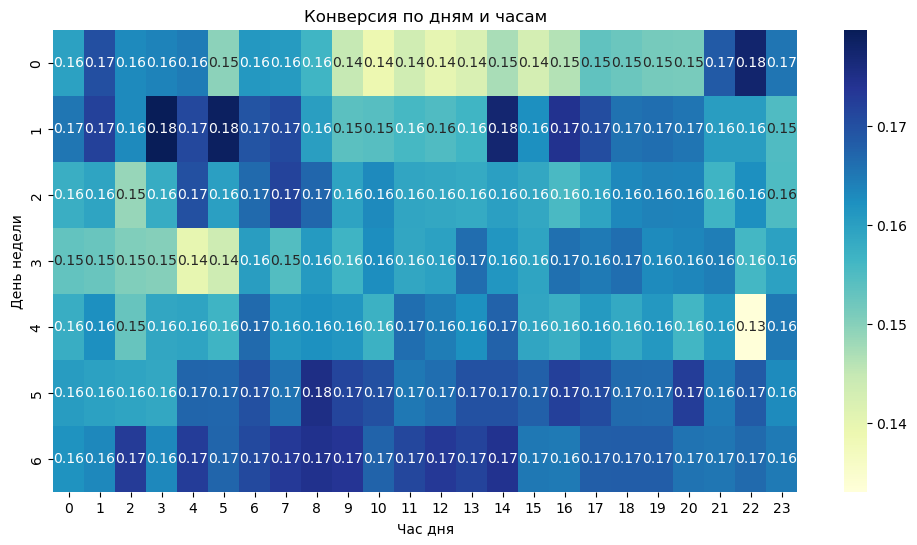

In [14]:
test5 = test4.copy()
#============================================================================
# Для каждого столбца с расширенным dtype приводим к соответствующему обычному:
for col, dtype in test5.dtypes.items():
    # IntegerDtype → int64
    if pd.api.types.is_integer_dtype(dtype):
        test5[col] = test5[col].astype('int64')
    # BooleanDtype → bool
    elif pd.api.types.is_bool_dtype(dtype):
        test5[col] = test5[col].astype('bool')
    # StringDtype → object (Python str)
    elif pd.api.types.is_string_dtype(dtype):
        test5[col] = test5[col].astype('object')
    # Остальные оставляем как есть (float уже float64 и т.д.)
#============================================================================
# Конверсии по utm_medium
cr_medium = test5.groupby('utm_medium')['is_target'].agg(['count', 'sum'])
cr_medium['conversion_rate'] = cr_medium['sum'] / cr_medium['count']
cr_medium = cr_medium.sort_values('conversion_rate', ascending=True)

# Визуализация
plt.figure(figsize=(8, 12))
sns.barplot(
    data=cr_medium.reset_index(),
    y='utm_medium',                # переместили utm_medium на ось Y
    x='conversion_rate',           # а conversion_rate на ось X
    orient='h'                     # явно указываем горизонтальную ориентацию
)
plt.title('Конверсия по utm_medium')
plt.xlabel('Conversion Rate')
plt.ylabel('UTM Medium')
plt.tight_layout()
plt.show()
#============================================================================
# Разбиваем aspect_ratio на бинты
n_bins = 10
test5['ar_bin'] = pd.qcut(test5['aspect_ratio'], q=n_bins, duplicates='drop')

# Считаем конверсию по бинту
cr_ar = (
    test5
    .groupby('ar_bin')['is_target']
    .agg(['count', 'sum'])
)
cr_ar['conversion_rate'] = cr_ar['sum'] / cr_ar['count']
cr_ar = cr_ar.reset_index()

# 3. Визуализация
plt.figure(figsize=(8, 5))
sns.barplot(
    data=cr_ar,
    x='conversion_rate',
    y='ar_bin',
    orient='h'
)
plt.xlabel('Conversion Rate')
plt.ylabel('Aspect Ratio Bin')
plt.title('Конверсия по бинам Aspect Ratio')
plt.tight_layout()
plt.show()
#============================================================================
# Расчёт конверсии по городам
cr_city = (
    test5
    .groupby('geo_city')['is_target']
    .agg(['count', 'sum'])
)
cr_city['conversion_rate'] = cr_city['sum'] / cr_city['count']
# Для наглядности оставим только топ-10 по объёму, либо можно вывести все города
cr_city_top = cr_city.sort_values('count', ascending=False).head(10).sort_values('conversion_rate')

# Горизонтальная столбчатая диаграмма
plt.figure(figsize=(8, 5))
sns.barplot(
    data=cr_city_top.reset_index(),
    y='geo_city',
    x='conversion_rate',
    orient='h'
)
plt.title('Конверсия по городам (топ-10 по числу сессий)')
plt.xlabel('Conversion Rate')
plt.ylabel('Город')
plt.tight_layout()
plt.show()

#============================================================================
# Расчёт конверсии по device_category
cr_device = test5.groupby('device_category')['is_target'].agg(['count', 'sum'])
cr_device['conversion_rate'] = cr_device['sum'] / cr_device['count']
cr_device = cr_device.sort_values('conversion_rate', ascending=True)

# Горизонтальная столбчатая диаграмма с seaborn
plt.figure(figsize=(6, 4))
sns.barplot(
    data=cr_device.reset_index(),
    y='device_category',
    x='conversion_rate',
    orient='h'
)
plt.title('Конверсия по устройству')
plt.xlabel('Conversion Rate')
plt.ylabel('Device Category')
plt.tight_layout()
plt.show()
#============================================================================
# Расчёт конверсии по номеру визита
cr_visit = (
    test5
    .groupby('visit_number')['is_target']
    .agg(['count', 'sum'])
)
cr_visit['conversion_rate'] = cr_visit['sum'] / cr_visit['count']
print(cr_visit)

# Визуализация (вертикальная столбчатая диаграмма)
plt.figure(figsize=(6,4))
sns.barplot(
    data=cr_visit.reset_index(),
    x='visit_number',
    y='conversion_rate'
)
plt.title('Конверсия по номеру визита')
plt.xlabel('Номер визита')
plt.ylabel('Conversion Rate')
plt.tight_layout()
plt.show()
#============================================================================
# Гистограммы глубины для целевых и нецелевых визитов
plt.figure(figsize=(10, 5))
sns.histplot(data=test5, x='hit_number', hue='is_target', bins=50, kde=True, stat="density")
plt.title('Глубина сессии: целевые vs нецелевые')
plt.xlabel('Hit Number')
plt.ylabel('Density')
plt.show()
#============================================================================
# Конверсия по часу и дню недели
heatmap_data = test5.groupby(['visit_weekday', 'visit_hour'])['is_target'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='.2f')
plt.title('Конверсия по дням и часам')
plt.ylabel('День недели')
plt.xlabel('Час дня')
plt.show()
#============================================================================



================================================== ДАННЫЕ ==================================================
Общее количество записей: 13,337,484
Количество признаков: 34

Типы данных:
                 count
object              18
int64               11
timedelta64[ns]      2
datetime64[ns]       1
Float32              1
category             1

Пропущенных значений нет

Дубликаты: 0 (0.00%)

Первые 3 записей:


,session_id,client_id,visit_datetime,visit_hour,visit_weekday,is_weekend,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_height,device_screen_width,device_browser,geo_country,geo_city,hit_time_td,hit_number,hit_referer,hit_page_path,event_category,event_action,event_label,is_target,aspect_ratio,ar_bin,n_hits,n_target_hits,n_unique_pages,session_duration
0,9055434745589932991.163775...,2108382700.1637753791,2021-11-24 14:36:32,14,2,0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,720,360,Chrome,russia,other_russia_city,0 days 00:00:03.665000,3,missing,podpiska.sberauto.com/,sub_page_view,sub_landing,missing,0,0.50,"(0.487, 0.5625]",4,1,1,0 days 00:00:42.927000
1,9055434745589932991.163775...,2108382700.1637753791,2021-11-24 14:36:32,14,2,0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,720,360,Chrome,russia,other_russia_city,0 days 00:00:46.592000,4,missing,podpiska.sberauto.com/,sub_button_click,sub_view_cars_click,vodKSlUobUWTVlgsJqdI,1,0.50,"(0.487, 0.5625]",4,1,1,0 days 00:00:42.927000
2,905544597018549464.1636867...,210838531.1636867288,2021-11-14 08:21:30,8,6,1,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,854,385,Samsung Internet,russia,Moscow,0 days 00:00:00.921000,3,missing,podpiska.sberauto.com/,sub_page_view,sub_landing,missing,0,0.45,"(0.4503, 0.4615]",3,0,1,0 days 00:00:00



------------------------------------------------------------
Полный анализ колонки: session_id
Пропуски: 0 (0.0%)
Уникальных значений: 1582604

Слишком много значений (> 50). Примеры:
['8245765966409638144.1624908032.1624908032'
 '8241363423078308706.1635441567.1635441567'
 '4373939286510895128.1637580824.1637580824'
 '472206371345539674.1625143375.1625143375'
 '4709941763545271226.1625590715.1625590715'
 '6940150106630014821.1636976455.1636976455'
 '7181792568794598250.1636485994.1636485994'
 '5028164162625680882.1638348275.1638348275'
 '6146986903964512621.1640526188.1640526188'
 '3801771852226018001.1627580833.1627580833']

Топ-10 значений:
session_id
1544572560279928739.1632436140.1632436140    120
5692861315757623740.1632356796.1632356796    120
6766315690481471549.1632423998.1632423998    116
6556325878862444653.1632368752.1632368752    116
6344040849605405862.1632382118.1632382118    116
4781656099508856169.1632511340.1632511340    116
477529334778357839.1632299092.1632299092  

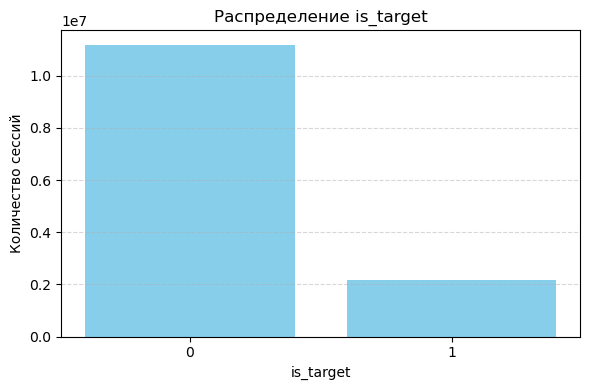

In [15]:
df = test5.copy()

# Сгруппируем по session_id и соберём агрегации
session_agg = df.groupby('session_id').agg(
    n_hits            = ('hit_number', 'max'),     # общее число хитов в сессии
    n_target_hits     = ('is_target', 'sum'),      # число целевых хитов
    n_unique_pages    = ('hit_page_path', 'nunique'),# число уникальных страниц
    first_hit_offset  = ('hit_time_td', 'min'),    # начало сессии
    last_hit_offset   = ('hit_time_td', 'max'),    # конец сессии
).reset_index()

# Продолжительность сессии
session_agg['session_duration'] = (
    session_agg['last_hit_offset'] - session_agg['first_hit_offset']
)

# Удаляем вспомогательные столбцы, если не нужны
session_agg = session_agg.drop(columns=['first_hit_offset', 'last_hit_offset'])

test6 = df.merge(session_agg, on='session_id', how='left')

summarize_dataset(test6, "Данные")


================================================== ДАННЫЕ ==================================================
Общее количество записей: 13,332,940
Количество признаков: 30

Типы данных:
         count
int32       14
object      13
float32      3

Пропущенных значений нет

Дубликаты: 0 (0.00%)

Первые 3 записей:


,session_id,client_id,visit_hour,visit_weekday,is_weekend,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_height,device_screen_width,device_browser,geo_country,geo_city,hit_number,is_target,aspect_ratio,n_hits,n_target_hits,n_unique_pages,visit_day,visit_month,visit_year,hit_sec,session_total_sec
0,9055434745589932991.163775...,2108382700.1637753791,14,2,0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,720,360,Chrome,russia,other_russia_city,3,0,0.50,4,1,1,24,11,2021,3.66,42.93
1,9055434745589932991.163775...,2108382700.1637753791,14,2,0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,720,360,Chrome,russia,other_russia_city,4,1,0.50,4,1,1,24,11,2021,46.59,42.93
2,905544597018549464.1636867...,210838531.1636867288,8,6,1,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,854,385,Samsung Internet,russia,Moscow,3,0,0.45,3,0,1,14,11,2021,0.92,0.00



------------------------------------------------------------
Полный анализ колонки: session_id
Пропуски: 0 (0.0%)
Уникальных значений: 1582604

Слишком много значений (> 50). Примеры:
['5918115917878896287.1623303840.1623303840'
 '4691526339657521831.1638718121.1638718121'
 '790215490944832066.1640436290.1640436290'
 '3931797554706606354.1628006673.1628006673'
 '1869745560764905309.1640068958.1640068958'
 '6942001516704946875.1634457946.1634457946'
 '8911668570850999446.1637235896.1637235896'
 '6739625994912556141.1640001911.1640001911'
 '556036865892521191.1636537577.1636537577'
 '567901279257002287.1637515569.1637515569']

Топ-10 значений:
session_id
5692861315757623740.1632356796.1632356796    120
1544572560279928739.1632436140.1632436140    120
477529334778357839.1632299092.1632299092     116
6766315690481471549.1632423998.1632423998    116
6556325878862444653.1632368752.1632368752    116
4781656099508856169.1632511340.1632511340    116
6344040849605405862.1632382118.1632382118   

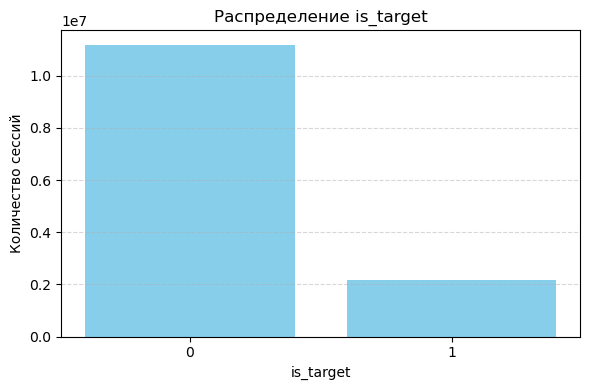

In [38]:
# Подготовка данных
df = test6.copy()

df['visit_day'] = df['visit_datetime'].dt.day
df['visit_month'] = df['visit_datetime'].dt.month
df['visit_year'] = df['visit_datetime'].dt.year
df['hit_sec'] = df['hit_time_td'].dt.total_seconds()
df['session_total_sec'] = df['session_duration'].dt.total_seconds()
df.drop('visit_datetime', axis=1, inplace=True)
df.drop('hit_time_td', axis=1, inplace=True)
df.drop('ar_bin', axis=1, inplace=True)
df.drop('session_duration', axis=1, inplace=True)
# Убираем слишком «текстовые» колонки с высокой кардинальностью
drop_cols = [
    'hit_referer', 'hit_page_path',
    'event_category', 'event_action', 'event_label'
]
df = df.drop(columns=drop_cols)

# Для каждого столбца с расширенным dtype приводим к соответствующему обычному:
for col, dtype in test6.dtypes.items():
    if pd.api.types.is_integer_dtype(dtype):
        test6[col] = test6[col].astype('int32')
    elif pd.api.types.is_bool_dtype(dtype):
        test6[col] = test6[col].astype('bool')
    elif pd.api.types.is_string_dtype(dtype):
        test6[col] = test6[col].astype('object')
    elif pd.api.types.is_float_dtype(dtype):
        test6[col] = test6[col].astype('float32')
    
int_cols = df.select_dtypes(include=['int64', 'Int64', 'Int32']).columns

df[int_cols] = df[int_cols].astype('int32')

float_cols = df.select_dtypes(include=['float64', 'Float64', 'Float32']).columns

df[float_cols] = df[float_cols].astype('float32')

for col in data.select_dtypes(['object']).columns:
    data[col] = data[col].astype(str)

df.drop_duplicates(inplace=True, keep='first')

summarize_dataset(df, "Данные")

In [39]:
print("\nСохраняем обработанные данные...")
data_out.mkdir(parents=True, exist_ok=True)
df.to_pickle(data_out / 'eda_data.pkl')
print(f"Данные сохранены в: {data_out}")


Сохраняем обработанные данные...
Данные сохранены в: /Users/aleksey.sushchikh/Desktop/GitHub/MIFIHackatonSberAutoSubscriptionAnalysis/data/eda_data
